In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/strat_weighted2.csv')
# Restrict to working age women
df = df[df['Gender'] == 'Female']
df = df[df['Age'] >= 15]

df.dropna(subset=['MPCE_qrt'], inplace=True)

# Rename state codes to state names
# states = pd.read_csv('data/state_codes.csv', header=None, index_col=0)[1].to_dict()
# df['state_codes'].replace(states, inplace=True)

# Process binary columns, those that need not be one-hot encoded
df['Urban'] = (df['sector'] == 'Urban').astype(int)
df['HH with children below age 6'] = (df['child'] == 'HH with children beloww age 6 ').astype(int)
df['Piped Gas/LPG Present'] = (df['piped_gas'] == 'Piped Gas/LPG Present').astype(int)
df['Dependent Adult'] = (df['old'] == 'HH with elderly person or PWD').astype(int)
df['Child and Dependent Adult'] = (df['old_child'] == 'HH with child & elderly person/PWD').astype(int)
df['Unemployed working age men'] = (df['n_unemp_men'] > 0).astype(int)

# Rename MPCE quartiles to be more readable
df['MPCE_qrt'].replace({'50-75': 'Third MPCE Quartile', '0-25': 'Lowest MPCE Quartile', '25-50': 'Second MPCE Quartile', '75-100': 'Top MPCE Quartile'}, inplace=True)

df.head()

,Age,Gender,state_codes,Total Children in HH,Total Women in HH,Total Additional Women in HH,education,marital_status,employment,Social_group_,...,Time Spent on Domestic Chores,Time Spent on Care Work,young_old,stratcode,Urban,HH with children below age 6,Piped Gas/LPG Present,Dependent Adult,Child and Dependent Adult,Unemployed working age men
1,61,Female,TN,1.0,2,1,Upto Middle School,Currently Married,Casual Labour,OBC,...,165.0,60.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,1,1,1,1,0
3,26,Female,TN,1.0,2,1,Secondary,Currently Married,Not Employed,OBC,...,345.0,120.0,Young,Young_TN_Female_OBC_Hinduism_Rural,0,1,1,1,1,0
4,70,Female,TN,0.0,1,0,Illiterate,Widowed,Not Employed,OBC,...,105.0,0.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,0,1,1,0,0
6,42,Female,TN,0.0,2,1,Illiterate,Currently Married,Not Employed,OBC,...,225.0,0.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,0,1,0,0,0
8,21,Female,TN,0.0,2,1,Graduate and above,Never Married,Self-Employed,OBC,...,165.0,0.0,Young,Young_TN_Female_OBC_Hinduism_Rural,0,0,1,0,0,0


# Table 4

In [8]:
# Create the common feature columns
sg_order = pd.CategoricalDtype(categories=['Others', 'ST', 'SC', 'OBC'], ordered=True)
df['Social group'] = df['Social_group_'].astype(sg_order)

religion_order = pd.CategoricalDtype(categories=['Hinduism', 'Islam', 'Christianity', 'Sikkhism', 'Jainism', 'Buddhism', 'Zoroastrianism', 'others'], ordered=True)
df['Religion'] = df['religion'].astype(religion_order)

df['MPCE'] = df['MPCE_qrt'].astype(pd.CategoricalDtype(categories=['Lowest MPCE Quartile', 'Second MPCE Quartile', 'Third MPCE Quartile', 'Top MPCE Quartile'], ordered=True))
df['Education'] = df['education'].astype(pd.CategoricalDtype(categories=['Illiterate', 'Upto Middle School', 'Secondary', 'Higher Secondary', 'Graduate and above'], ordered=True))

xComm = pd.concat(
    [ 
        df[['Urban', 'Age']],
        pd.get_dummies(df[['Social group', 'Religion', 'MPCE', 'Education']], drop_first=True, prefix='', prefix_sep='').astype(int),
        # pd.get_dummies(df['state_codes'], prefix="", prefix_sep="").astype(int)
    ],
    axis=1)
# List the spec columns
df['Child'] = (df['child'] == 'HH with children beloww age 6 ').astype(int)
df['Adult with special need'] = df['special_need']
df['No. of working women'] = df['n_working_women']
df['Unemployed working-age men'] = df['n_unemp_men']
df['Employed Help'] = df['employed_help']

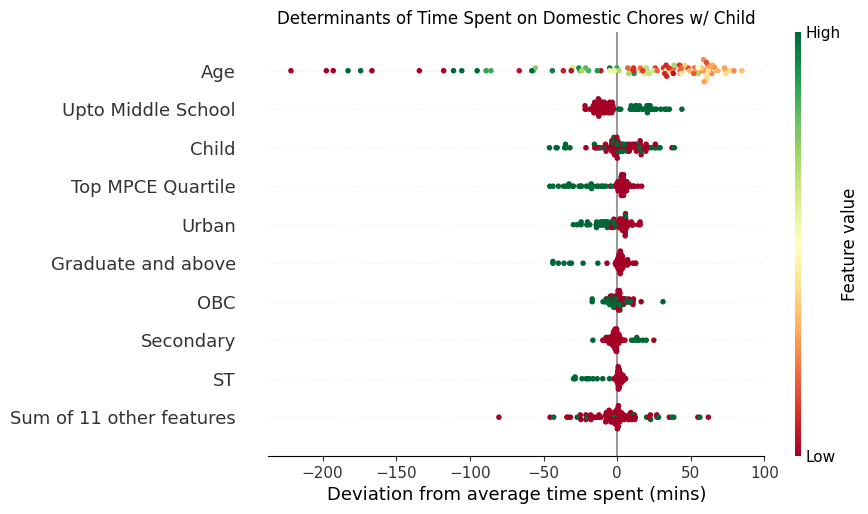

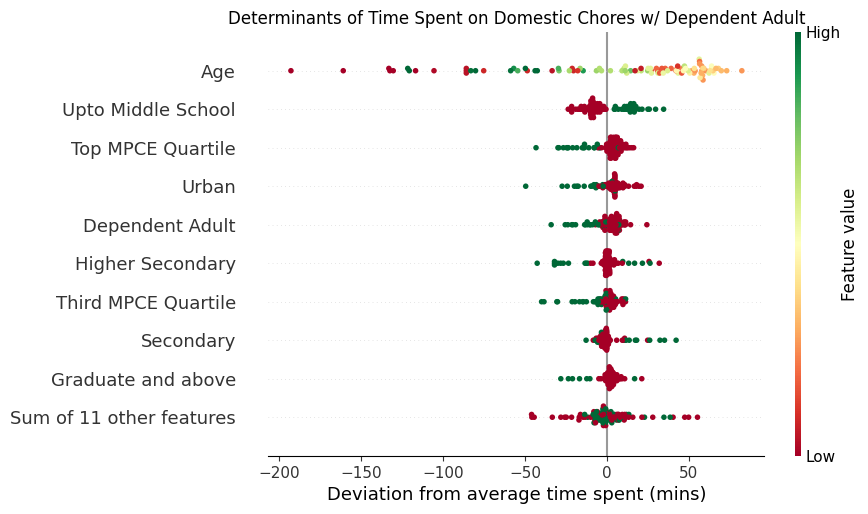

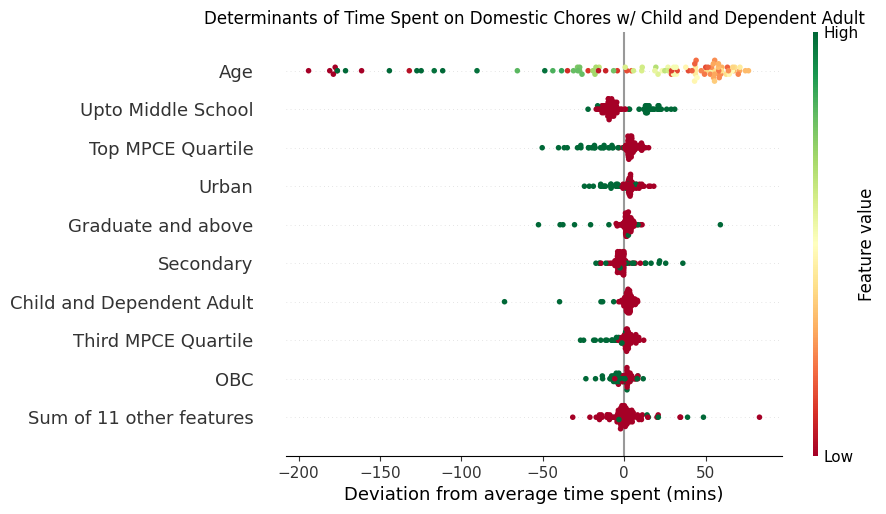

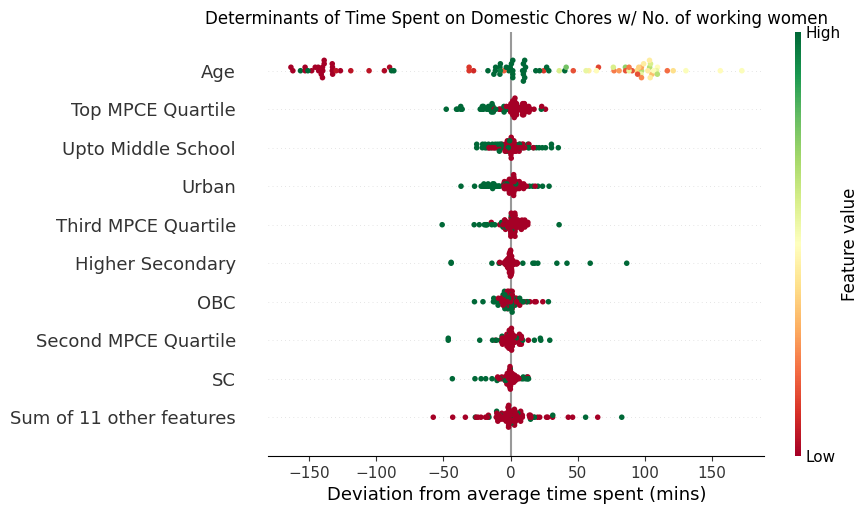

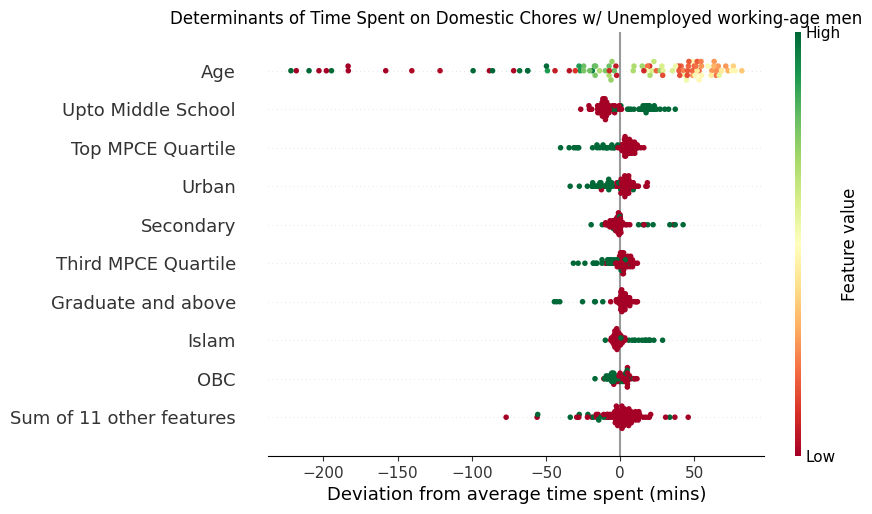

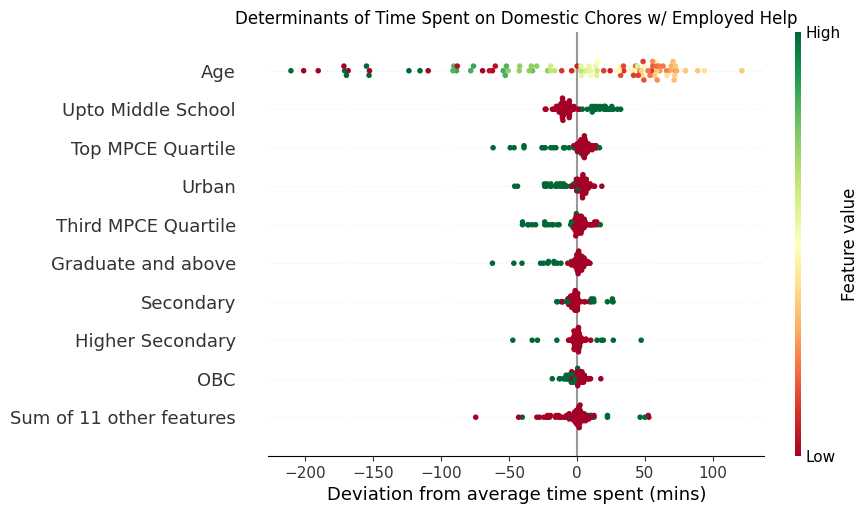

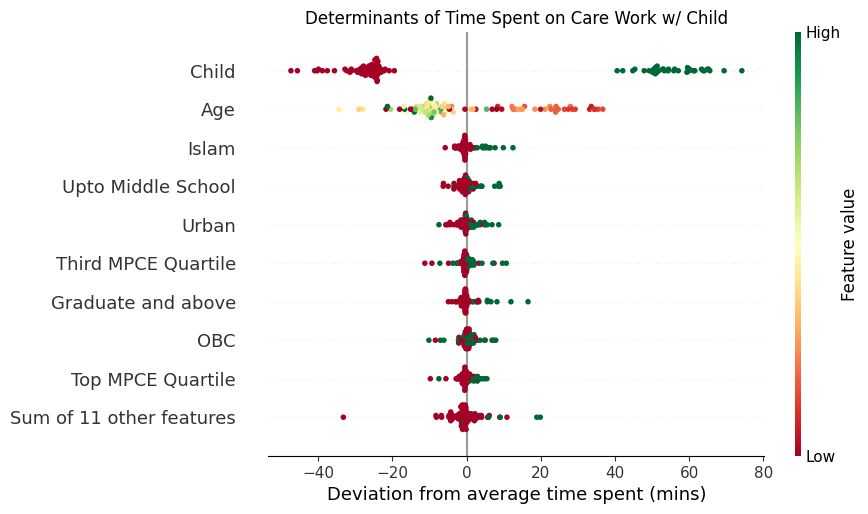

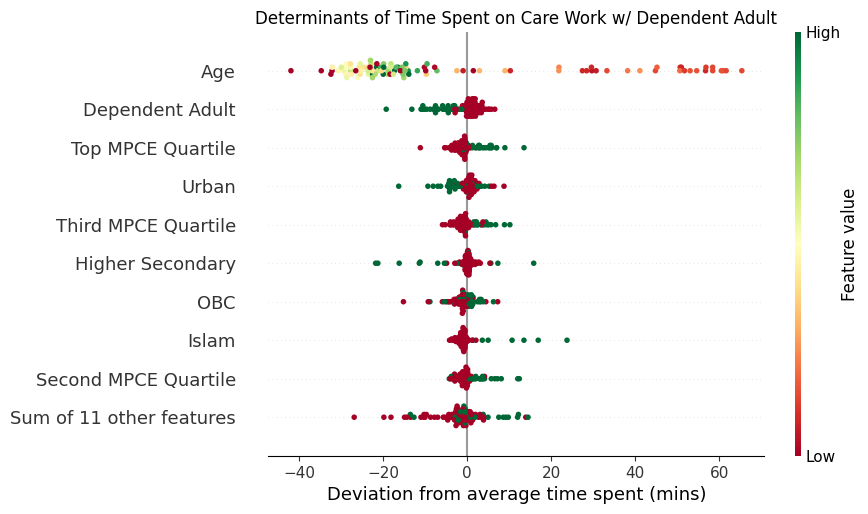

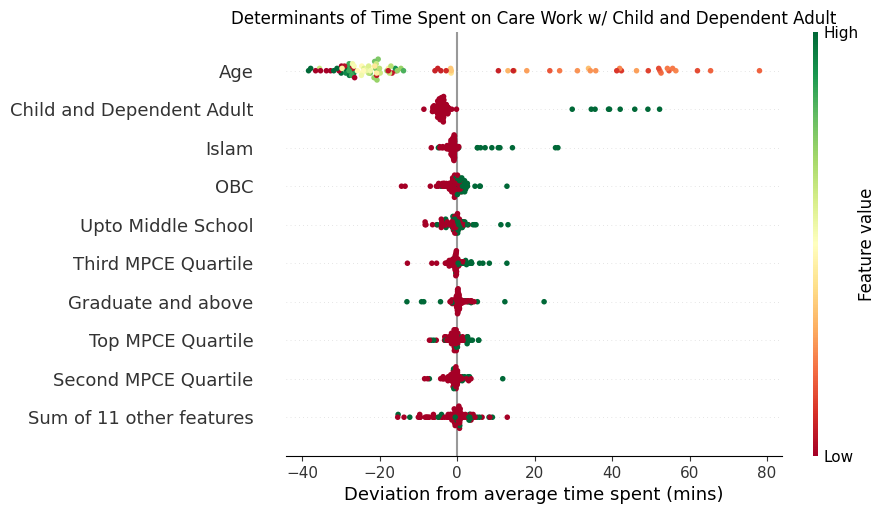

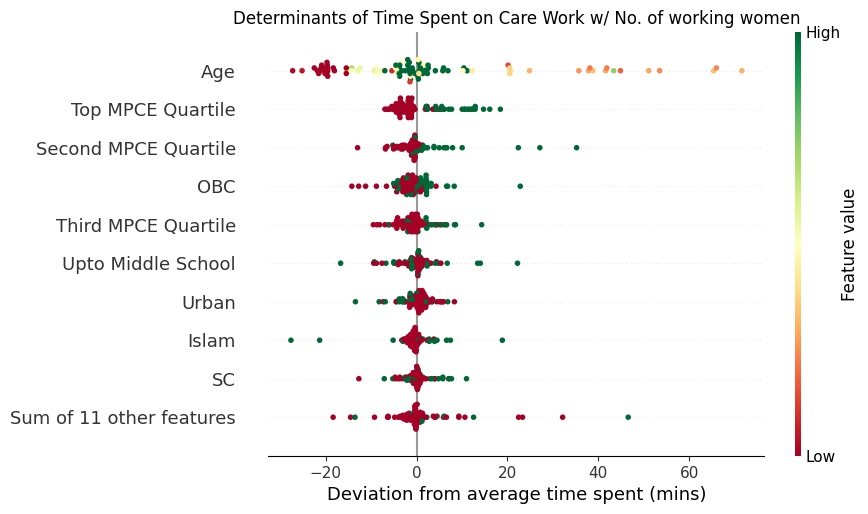

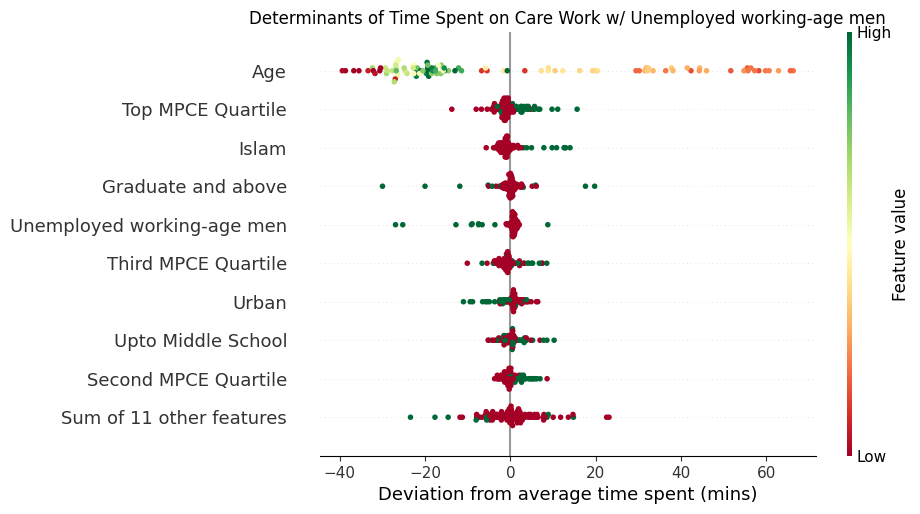

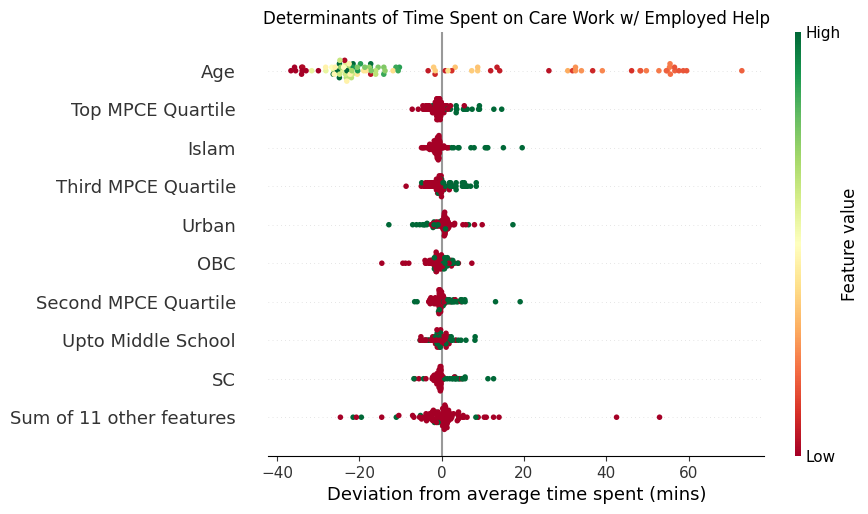

In [10]:
spec_cols = ['Child', 'Dependent Adult', 'Child and Dependent Adult', #'Adult with special need',
             'No. of working women', 'Unemployed working-age men', 'Employed Help']
targets = ['Time Spent on Domestic Chores', 'Time Spent on Care Work']

n_samples = 100

for t in targets:
    for spec in spec_cols:
        X = pd.concat((df[spec], xComm, df[t], df['pweight']), axis=1)
        X.dropna(inplace=True)
        if spec == "No. of working women":
            X = X[X[spec] > 0]
        y = X.pop(t)
        weight = X.pop('pweight')
        clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weight)
        # print(t, spec, clf.score(X, y, weight))
        exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
        vals = exp(X.sample(n_samples, weights=weight), check_additivity=False)
        plt.figure()
        beeswarm(vals, color='RdYlGn', show=False)
        ax = plt.gca()
        ax.set_title(f'Determinants of {t} w/ {spec}')
        ax.set_xlabel('Deviation from average time spent (mins)')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


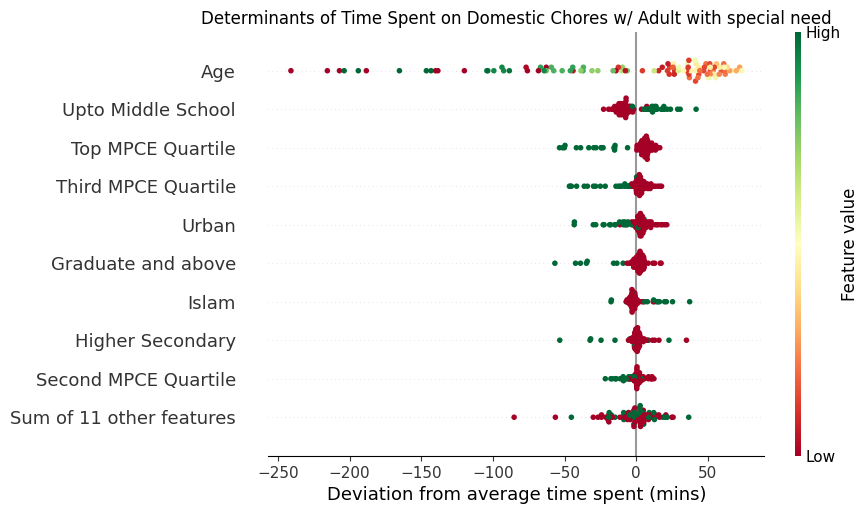

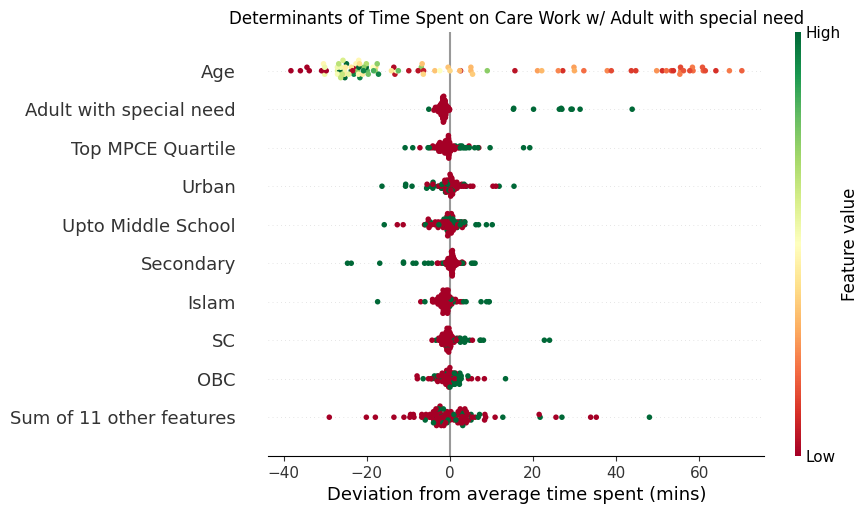

In [11]:
# Adult with special need
ix = df['Adult with special need'].notna()
xdf = df.iloc[ix.values]
xdfComm = xComm.iloc[ix.values]
xdf.replace({'Adult with special need': {2: 0}}, inplace=True)

for t in targets:
    for spec in ['Adult with special need']:
        X = pd.concat((xdf[spec], xdfComm, xdf[t], df['pweight']), axis=1)
        X.dropna(inplace=True)
        y = X.pop(t)
        weight = X.pop('pweight')
        clf = RandomForestRegressor(n_jobs=-1, max_depth=20, max_features='sqrt').fit(X, y, sample_weight=weight)
        exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
        vals = exp(X.sample(n_samples, weights=weight), check_additivity=False)
        plt.figure()
        beeswarm(vals, color='RdYlGn', show=False)
        ax = plt.gca()
        ax.set_title(f'Determinants of {t} w/ {spec}')
        ax.set_xlabel('Deviation from average time spent (mins)')

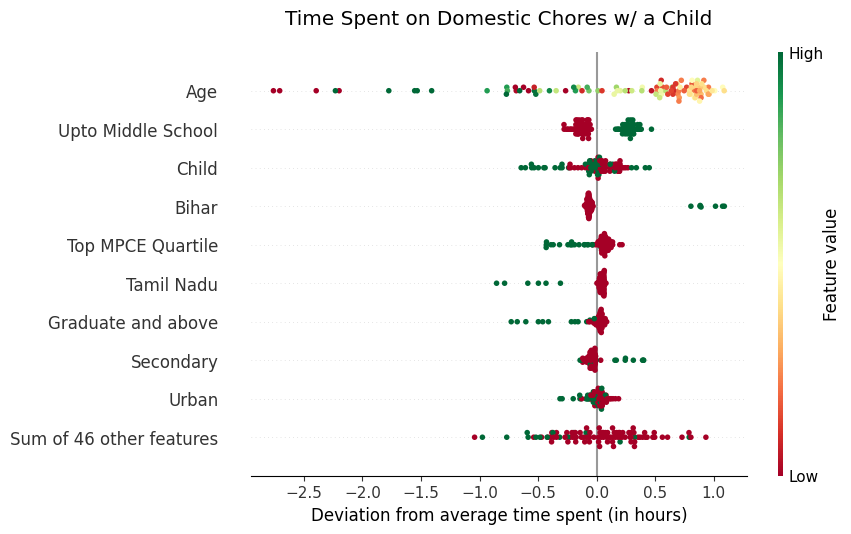

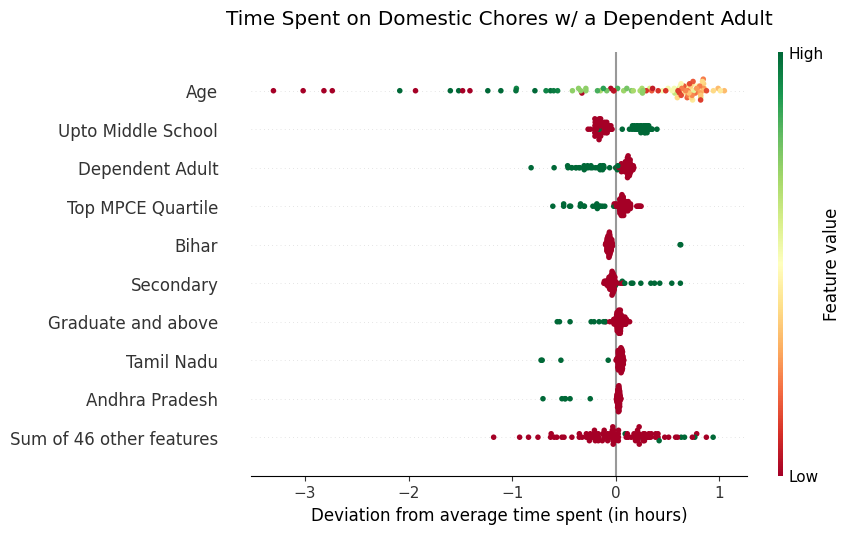

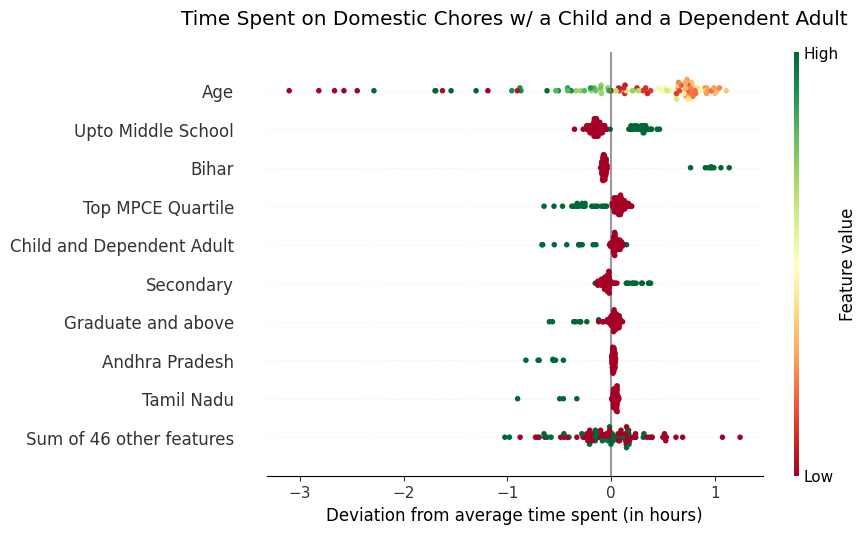

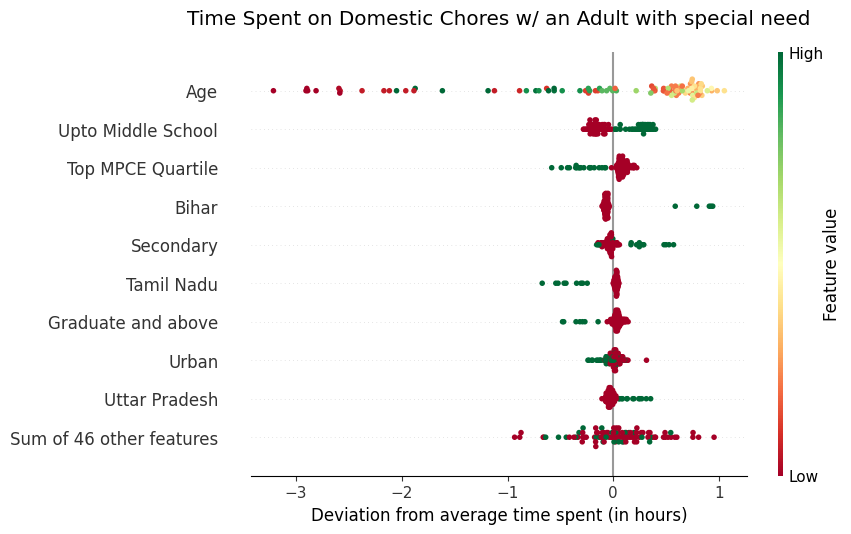

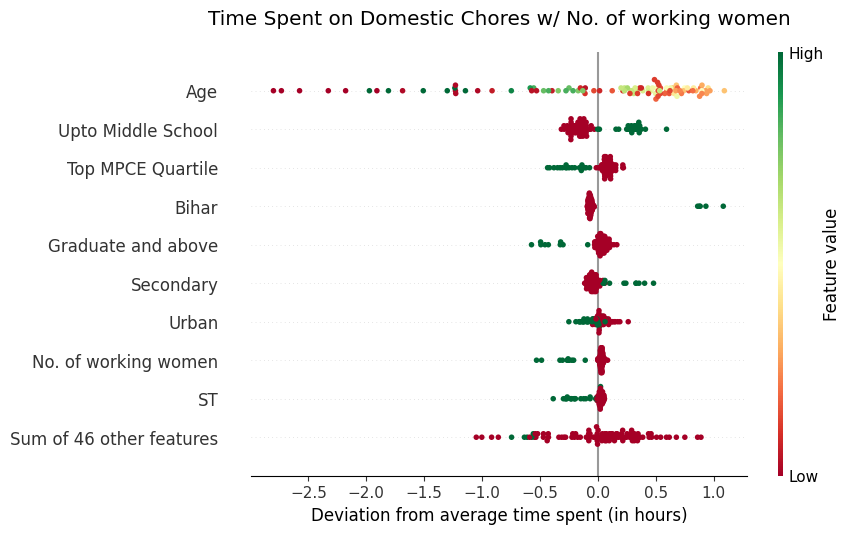

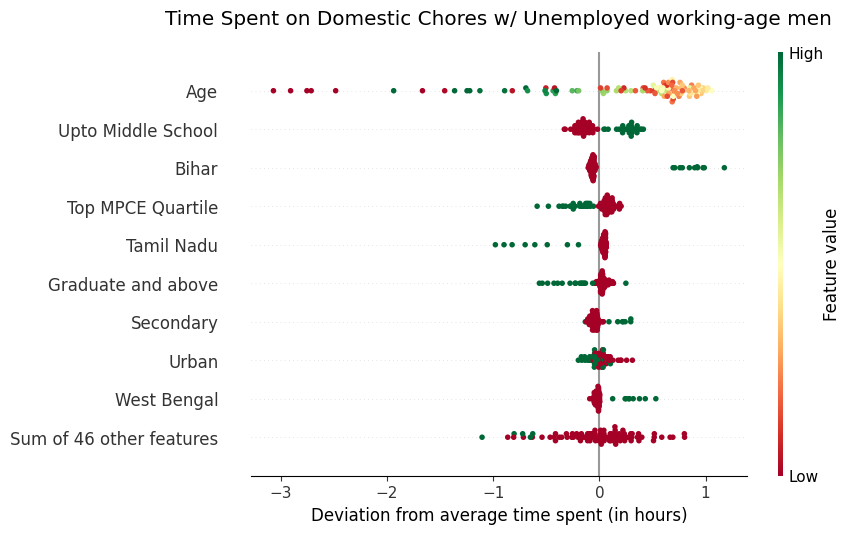

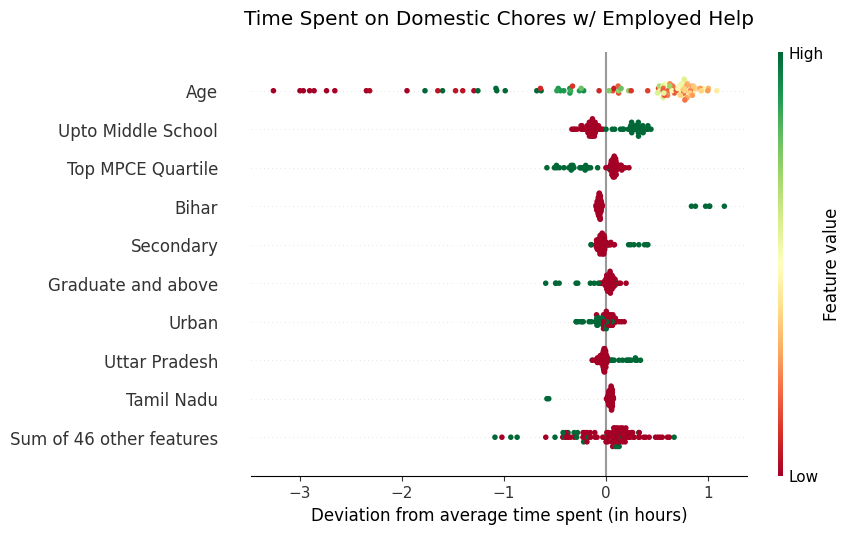

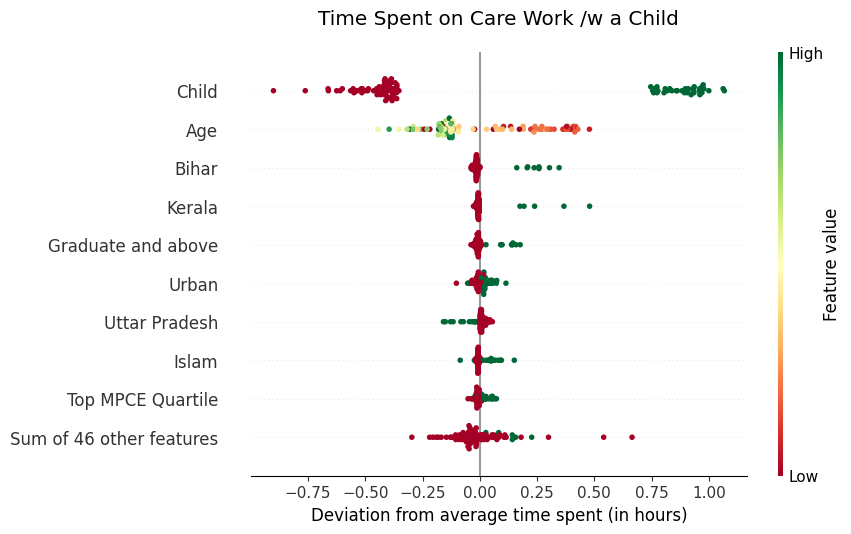

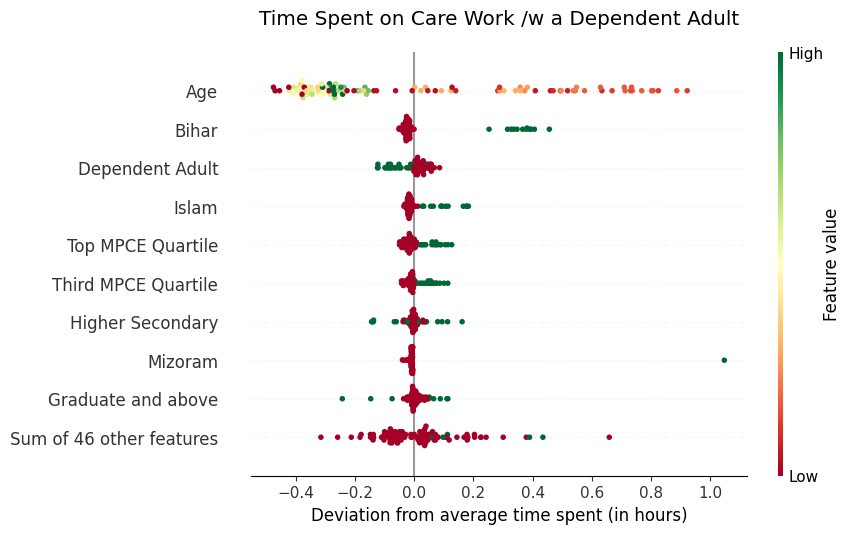

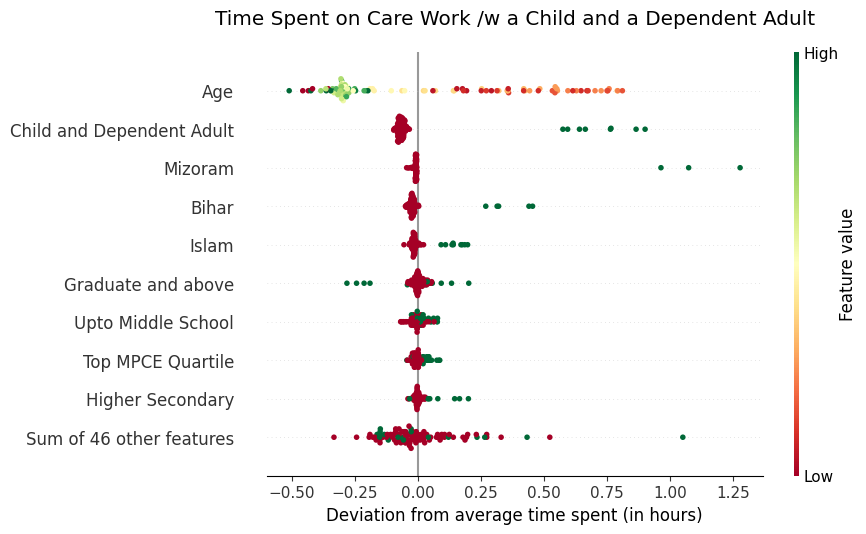

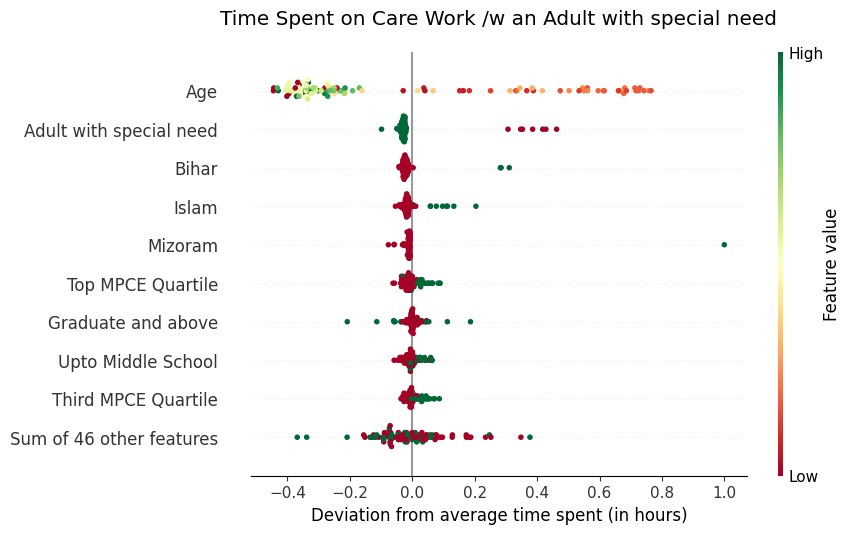

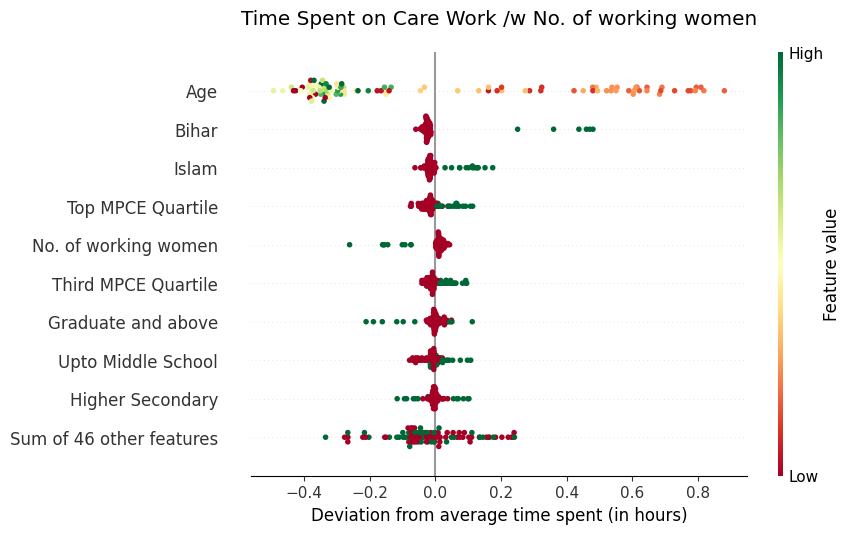

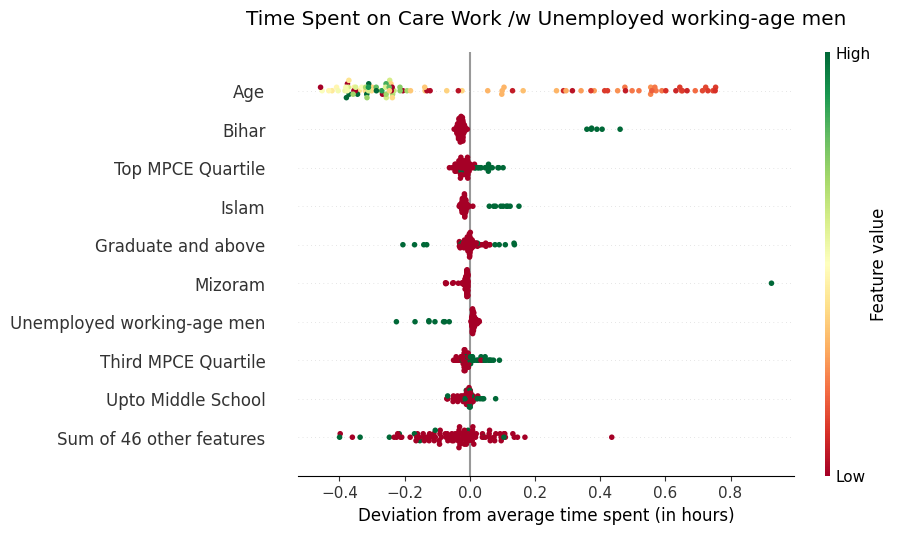

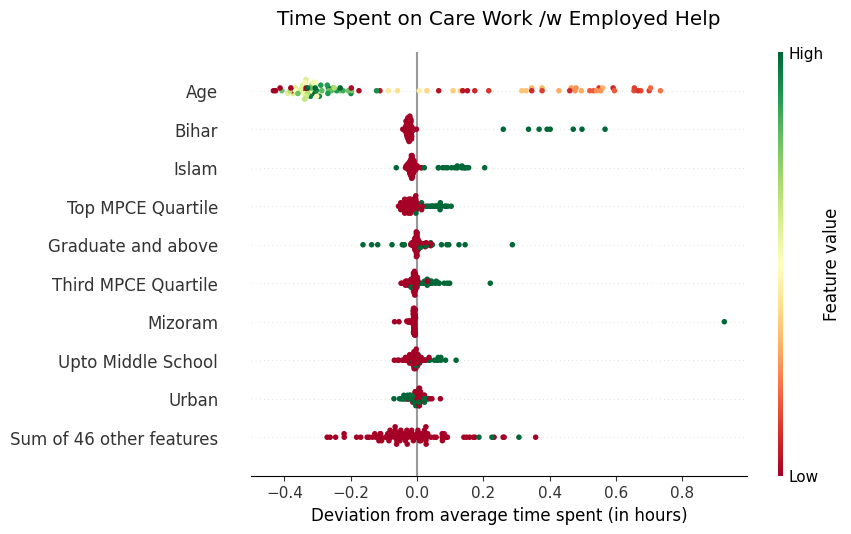

In [6]:
# Draw table 4 beeswarms

clf = RandomForestRegressor(n_jobs=-1, max_depth=30, min_samples_leaf=4,
                                  min_samples_split=5, n_estimators=300, max_features='sqrt')

titles = [
    "Time Spent on Domestic Chores w/ a Child",
    "Time Spent on Domestic Chores w/ a Dependent Adult",
    "Time Spent on Domestic Chores w/ a Child and a Dependent Adult",
    "Time Spent on Domestic Chores w/ an Adult with special need",
    "Time Spent on Domestic Chores w/ No. of working women",
    "Time Spent on Domestic Chores w/ Unemployed working-age men",
    "Time Spent on Domestic Chores w/ Employed Help",
    "Time Spent on Care Work /w a Child",
    "Time Spent on Care Work /w a Dependent Adult",
    "Time Spent on Care Work /w a Child and a Dependent Adult",
    "Time Spent on Care Work /w an Adult with special need",
    "Time Spent on Care Work /w No. of working women",
    "Time Spent on Care Work /w Unemployed working-age men",
    "Time Spent on Care Work /w Employed Help"
]
n_samples = 100
i = 0
for t in targets:
    for spec in spec_cols:
        X = pd.concat((df[spec], xComm, df[t]), axis=1)
        X.dropna(inplace=True)
        y = X.pop(t)
        clf.fit(X, y / 60)
        exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
        # _, samples = train_test_split(X, stratify=df['stratcode'], test_size=100)
        # samples = pd.concat((samples[spec], xComm, samples[t]), axis=1)
        vals = exp(X.sample(n_samples), check_additivity=False)
        
        plt.figure()
        beeswarm(vals, color='RdYlGn', show=False)
        ax = plt.gca()
        ax.set_title(titles[i], fontsize='x-large', pad=20)
        ax.tick_params(axis='y', labelsize='large')
        ax.set_xlabel('Deviation from average time spent (in hours)', fontsize='large')
        i += 1